<a href="https://colab.research.google.com/github/markvasin/deep_learning_exercise/blob/master/lab2/lab2_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from typing import Tuple

In [ ]:
def sgd_factorise_ad(A: torch.Tensor, rank: int, num_epochs=1000, lr=0.01):
  row, col = A.shape
  U = torch.rand(row, rank, requires_grad=True)
  V = torch.rand(col, rank, requires_grad=True)
  for epoch in range(0, num_epochs):
    J = torch.nn.functional.mse_loss(U@V.T, A, reduction='sum')
    J.backward()
    with torch.no_grad():
      U -= lr * U.grad
      V -= lr * V.grad
      U.grad.zero_()
      V.grad.zero_()    
  return U, V

In [ ]:
A = torch.tensor([[0.3374, 0.6005, 0.1735], [3.3359, 0.0492, 1.8374], [2.9407, 0.5301, 2.2620]])
print(A)
U,V = sgd_factorise_ad(A, 2, num_epochs=1000)
print(U)
print(V)
print(U @ V.T)
loss = torch.nn.functional.mse_loss(U@V.T, A, reduction='sum')
print(loss)

tensor([[0.3374, 0.6005, 0.1735],
        [3.3359, 0.0492, 1.8374],
        [2.9407, 0.5301, 2.2620]])
tensor([[-0.2286,  0.6381],
        [ 1.5551,  0.4164],
        [ 1.0623,  1.0964]], requires_grad=True)
tensor([[ 1.8227,  1.0049],
        [-0.2049,  0.7440],
        [ 1.0208,  0.9282]], requires_grad=True)
tensor([[ 0.2246,  0.5216,  0.3590],
        [ 3.2529, -0.0089,  1.9740],
        [ 3.0380,  0.5981,  2.1021]], grad_fn=<MmBackward>)
tensor(0.1219, grad_fn=<MseLossBackward>)


In [ ]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None )
data = torch.tensor(df.iloc[:, [ 0 , 1 , 2 , 3 ] ].values, dtype=torch.float32)
data = data - data.mean(dim=0)

In [ ]:
U_hat,V_hat = sgd_factorise_ad(data, 2)
# print(U)
# print(V)
# print(U @ V.T)
print(U_hat.shape)
print(V_hat.shape)
loss = torch.nn.functional.mse_loss(U_hat@V_hat.T, data, reduction='sum')
print(loss.item())

torch.Size([150, 2])
torch.Size([4, 2])
15.230057716369629


In [ ]:
# Truncated SVD
U,S,V = torch.svd(data)
print(S)
S[-2:] = 0
print(S)
# print(U)
# print(V)
# print(U@torch.diag(S)@V.T)
loss = torch.nn.functional.mse_loss(U@torch.diag(S)@V.T, data, reduction='sum')
print(loss.item())

tensor([25.0899,  6.0079,  3.4205,  1.8785])
tensor([25.0899,  6.0079,  0.0000,  0.0000])
15.22883129119873


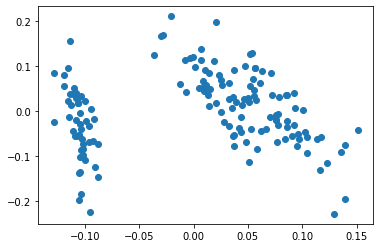

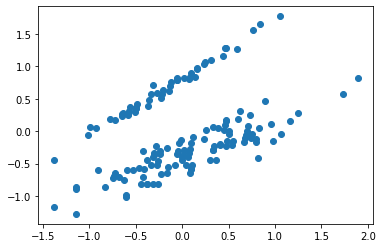

In [ ]:
import matplotlib.pyplot as plt

X_1 = U[:,0:2]
X_2 = U_hat.detach().numpy()

plt.scatter(X_1[:,0], X_1[:,1])
plt.show()

plt.scatter(X_2[:,0], X_2[:,1])
plt.show()

In [ ]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None )
df = df.sample(frac=1) #shuffle

# add label indices column
mapping = {k: v for v, k in enumerate(df[4].unique())}
df[5] = df[4].map(mapping)

# normalise data
alldata = torch.tensor(df.iloc[:, [0,1,2,3]].values, dtype=torch.float)
alldata = (alldata - alldata.mean(dim=0)) / alldata.var(dim=0)
                                                        
# create datasets
targets_tr = torch.tensor(df.iloc[:100, 5].values, dtype=torch.long)
targets_va = torch.tensor(df.iloc[100:, 5].values, dtype=torch.long)
data_tr = alldata[:100]
data_va = alldata[100:]

tensor([1, 1, 0, 1, 2, 2, 1, 1, 2, 1, 0, 1, 0, 2, 0, 1, 1, 2, 2, 0, 1, 1, 1, 1,
        2, 2, 0, 2, 0, 2, 2, 0, 1, 0, 2, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 0, 1, 1,
        1, 1])


In [ ]:
num_epochs = 10000
lr = 0.01
W1 = torch.randn(4, 12, requires_grad=True)
W2 = torch.randn(12, 3, requires_grad=True)
b1 = torch.tensor([0], requires_grad=True, dtype=torch.float)
b2 = torch.tensor([0], requires_grad=True, dtype=torch.float)

for epoch in range(0, num_epochs):
  logits = torch.relu(data_tr @ W1 + b1) @ W2 + b2
  J = torch.nn.functional.cross_entropy(logits, targets_tr)
  J.backward()
  with torch.no_grad():
    W1 -= lr * W1.grad
    W2 -= lr * W2.grad
    b1 -= lr * b1.grad
    b2 -= lr * b2.grad

    W1.grad.zero_()
    W2.grad.zero_()
    b1.grad.zero_()
    b2.grad.zero_()


train_logits = torch.relu(data_tr @ W1 + b1) @ W2 + b2
train_preds = torch.argmax(train_logits, dim=1)
print('Training accuracy:', (train_preds == targets_tr).float().mean().item())

validation_logits = torch.relu(data_va @ W1 + b1) @ W2 + b2
validation_preds = torch.argmax(validation_logits, dim=1)
print('Validation accuracy:', (validation_preds == targets_va).float().mean().item())

Training accuracy: 0.9399999976158142
Validation accuracy: 0.9800000190734863
